# Part1 - Preprocessing

## Import libaries

In [284]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
import talib as ta

## Import training set

In [285]:
rsiPeriod = 14
adxPeriod = 14
bollingerBandWindow = 20
trainingDataPoints = 3500
window = 60

In [286]:
variablesToInclude = ['Close','Volume',"RSI","ADX","fastd","fastk","macd"]
numberOfFeatures = len(variablesToInclude)
numberOfFeatures

7

In [287]:
dataTrain = pd.read_csv("/Users/ishan/Coding/Wpi/StockMarketSimulationIQP/BriannaCode/30y_stock_csvs/GOOG.csv") #import csv
dataTrain.rename(columns = {'CLOSE':'Close'}, inplace = True)
dataTrain.rename(columns = {'HIGH':'High'}, inplace = True)
dataTrain.rename(columns = {'LOW':'Low'}, inplace = True)
dataTrain.rename(columns = {'VOLUME':'Volume'}, inplace = True)

In [288]:

dataTrain['Close'] = dataTrain['Close'].astype(float).fillna(0)
# dataTrain['Close'][1:] = dataTrain['Close'][0:-1]
dataTrain["RSI"] = ta.RSI(dataTrain['Close'],rsiPeriod).fillna(0)
dataTrain["ADX"] = ta.ADX(dataTrain['High'],dataTrain['Low'],dataTrain['Close'],adxPeriod).fillna(0)
fastk, fastd = ta.STOCHF(dataTrain['High'],dataTrain['Low'],dataTrain['Close'])
dataTrain['fastd'] = fastd
dataTrain['fastk'] = fastk
macd, macdsignal, macdhist = ta.MACD(dataTrain['Close'])
dataTrain['macd'] = macd
dataTrain['macdsignal'] = macdsignal
dataTrain['macdhist'] = macdhist
upper,middle,lower = ta.BBANDS(dataTrain['Close'])
dataTrain['bb_lowerband'] = lower
dataTrain['bb_middleband'] = middle
dataTrain['bb_upperband'] = upper


In [289]:
newTrain = pd.DataFrame()
newTrain = dataTrain[variablesToInclude]
newTrain

Close    Volume        RSI        ADX      fastd      fastk  \
0       49.982655  44871361   0.000000   0.000000        NaN        NaN   
1       53.952770  22942874   0.000000   0.000000        NaN        NaN   
2       54.495735  18342897   0.000000   0.000000        NaN        NaN   
3       52.239197  15319808   0.000000   0.000000        NaN        NaN   
4       52.802086   9232276   0.000000   0.000000        NaN        NaN   
...           ...       ...        ...        ...        ...        ...   
4399  2784.260010   1712800  50.882631  23.278061  31.491212  15.367453   
4400  2829.060059   1431400  54.046814  22.287940  25.898736  37.403971   
4401  2772.050049   1650900  49.662401  20.858130  25.114388  22.571739   
4402  2682.600098   1937700  43.675611  20.125105  22.648670   7.970300   
4403  2684.860107    876416  43.859754  19.444438  13.760832  10.740457   

           macd  
0           NaN  
1           NaN  
2           NaN  
3           NaN  
4           NaN  
...         ...  
4399  -2.303228  
4400   2.650197  
4401   1.953076  
4402  -5.750967  
4403 -11.541074  

[4404 rows x 7 columns]

In [290]:

trainingSet = newTrain.iloc[:,0:numberOfFeatures].values #convert to numpy to train RNN
ySet = dataTrain['Close'].astype(float).values.reshape(-1, 1)
trainingSet

array([[ 4.99826546e+01,  4.48713610e+07,  0.00000000e+00, ...,
                    nan,             nan,             nan],
       [ 5.39527702e+01,  2.29428740e+07,  0.00000000e+00, ...,
                    nan,             nan,             nan],
       [ 5.44957352e+01,  1.83428970e+07,  0.00000000e+00, ...,
                    nan,             nan,             nan],
       ...,
       [ 2.77205005e+03,  1.65090000e+06,  4.96624008e+01, ...,
         2.51143879e+01,  2.25717390e+01,  1.95307634e+00],
       [ 2.68260010e+03,  1.93770000e+06,  4.36756107e+01, ...,
         2.26486701e+01,  7.97029983e+00, -5.75096667e+00],
       [ 2.68486011e+03,  8.76416000e+05,  4.38597538e+01, ...,
         1.37608321e+01,  1.07404574e+01, -1.15410740e+01]])

## Feature Scaling

In [291]:
# Use normalization x - min(x) / max(min) - min(x)
sc = MinMaxScaler(feature_range=(0,1)) # all values between 0 and 1
ySC = MinMaxScaler(feature_range=(0,1))
ySCSet = ySC.fit_transform(ySet)
scaleTrainingSet = sc.fit_transform(trainingSet)
scaleTrainingSet

array([[5.54543500e-05, 5.43577158e-01, 0.00000000e+00, ...,
                   nan,            nan,            nan],
       [1.39473616e-03, 2.77885876e-01, 0.00000000e+00, ...,
                   nan,            nan,            nan],
       [1.57790036e-03, 2.22151352e-01, 0.00000000e+00, ...,
                   nan,            nan,            nan],
       ...,
       [9.18319723e-01, 1.99067511e-02, 5.46164135e-01, ...,
        2.41314577e-01, 2.25717390e-01, 5.31873147e-01],
       [8.88144609e-01, 2.33816949e-02, 4.80324184e-01, ...,
        2.15795547e-01, 7.97029983e-02, 4.88827761e-01],
       [8.88907002e-01, 1.05229004e-02, 4.82349305e-01, ...,
        1.23810570e-01, 1.07404574e-01, 4.56476253e-01]])

## Create a data structure woth 60 timesteps and 1 output

In [295]:
# Look at the 60 previous timesteps to predict this timestep
xTrain = []
yTrain = []
for i in range(33 + window,trainingDataPoints):
    xTrain.append(scaleTrainingSet[i-window:i])
    yTrain.append(ySCSet[i])
xTrain

[array([[0.00622926, 0.16280724, 0.84925922, 0.69371481, 0.92243319,
         0.84942943, 0.54528036],
        [0.00652669, 0.17173877, 0.86218209, 0.70851319, 0.92755152,
         0.90619307, 0.54587952],
        [0.00633849, 0.13466269, 0.83290119, 0.72225455, 0.83495607,
         0.71858668, 0.5458163 ],
        [0.00592343, 0.12739   , 0.77073499, 0.71658732, 0.67828466,
         0.39528893, 0.54493511],
        [0.00628304, 0.14191834, 0.79215627, 0.70885997, 0.57861566,
         0.61728439, 0.54444664],
        [0.00687118, 0.24053494, 0.82380081, 0.71299864, 0.58562892,
         0.7389159 , 0.54457337],
        [0.00705602, 0.12702515, 0.8330862 , 0.70897529, 0.7415627 ,
         0.84729126, 0.54464781],
        [0.00741059, 0.16053544, 0.85041706, 0.71079389, 0.83396311,
         0.88512374, 0.54490466],
        [0.00825919, 0.17078043, 0.88619131, 0.71815172, 0.92315957,
         0.99746802, 0.54595426],
        [0.00805418, 0.22037088, 0.85430188, 0.72922452, 0.86466898,
    

In [296]:
# convert xtrain and yTrain to numpy for RNN
xTrain, yTrain = np.array(xTrain), np.array(yTrain)

## Reshaping the data

In [297]:
xTrain = np.reshape(xTrain, (xTrain.shape[0],xTrain.shape[1],numberOfFeatures)) #batchsize, inputSize, numberOfFeatures

# Part 2 - Build RNN

## Initalizing the RNN

In [298]:
regressor = Sequential()


## Adding LSTM layers and some dropout regularization

In [299]:
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (xTrain.shape[1],numberOfFeatures))) 
regressor.add(Dropout(rate = 0.2))
#regressor.add(Dense(units=16,activation = 'relu',input_shape = (xTrain.shape[1],numberOfFeatures)))

In [300]:
regressor.add(LSTM(units = 50, return_sequences = True)) 
regressor.add(Dropout(rate = 0.2))
#regressor.add(Dense(units=32,activation = 'relu'))

In [301]:
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(rate = 0.2))
#regressor.add(Dense(units=16,activation = 'relu'))

In [302]:
regressor.add(LSTM(units = 50))
regressor.add(Dropout(rate = 0.2))
# Last Layer
regressor.add(Dense(units=1))#output layer, default since this is regression not classfition 

## Adding output layer

In [303]:
regressor.compile(optimizer='adam',loss='mean_squared_error',metrics='accuracy')

In [304]:
regressor.fit(xTrain,yTrain,epochs=100,batch_size=32)

Epoch 1/100
107/107 [==============================] - 11s 59ms/step - loss: 0.0029 - accuracy: 0.0000e+00
Epoch 2/100
107/107 [==============================] - 6s 56ms/step - loss: 4.6306e-04 - accuracy: 0.0000e+00
Epoch 3/100
107/107 [==============================] - 6s 56ms/step - loss: 3.7112e-04 - accuracy: 0.0000e+00
Epoch 4/100
107/107 [==============================] - 6s 58ms/step - loss: 3.1759e-04 - accuracy: 0.0000e+00
Epoch 5/100
107/107 [==============================] - 6s 60ms/step - loss: 2.8725e-04 - accuracy: 0.0000e+00
Epoch 6/100
107/107 [==============================] - 7s 64ms/step - loss: 2.6321e-04 - accuracy: 0.0000e+00
Epoch 7/100
107/107 [==============================] - 6s 59ms/step - loss: 2.4497e-04 - accuracy: 0.0000e+00
Epoch 8/100
107/107 [==============================] - 6s 60ms/step - loss: 2.2663e-04 - accuracy: 0.0000e+00
Epoch 9/100
107/107 [==============================] - 6s 60ms/step - loss: 2.2449e-04 - accuracy: 0.0000e+00
Epoch 10/100


## Part 3 - Predictions and visualing the results

In [305]:
dataTest = pd.read_csv("/Users/ishan/Coding/Wpi/StockMarketSimulationIQP/BriannaCode/30y_stock_csvs/GOOG.csv") #import csv
dataTest.rename(columns = {'CLOSE':'Close'}, inplace = True)
dataTest.rename(columns = {'HIGH':'High'}, inplace = True)
dataTest.rename(columns = {'LOW':'Low'}, inplace = True)
dataTest.rename(columns = {'VOLUME':'Volume'}, inplace = True)

In [306]:

dataTest = dataTest[trainingDataPoints + 1:]
dataTest['CloseEdited'] = dataTest['Close'].astype(float)
dataTest["RSI"] = ta.RSI(dataTest['CloseEdited'],rsiPeriod)
dataTest["ADX"] = ta.ADX(dataTest['High'],dataTest['Low'],dataTest['CloseEdited'],adxPeriod)
fastk, fastd = ta.STOCHF(dataTest['High'],dataTest['Low'],dataTest['CloseEdited'])
dataTest['fastd'] = fastd
dataTest['fastk'] = fastk
macd, macdsignal, macdhist = ta.MACD(dataTest['CloseEdited'])
dataTest['macd'] = macd
dataTest['macdsignal'] = macdsignal
dataTest['macdhist'] = macdhist
upper,middle,lower = ta.BBANDS(dataTest['CloseEdited'])
dataTest['bb_lowerband'] = lower
dataTest['bb_middleband'] = middle
dataTest['bb_upperband'] = upper


In [307]:
newTest = pd.DataFrame()
newTest = dataTest[variablesToInclude]
newTest["Close"][1:] = newTest["Close"][0:-1]
newTest

/Users/ishan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/ishan/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:998: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_with(key, value)
/Users/ishan/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/sta

Close   Volume        RSI        ADX      fastd      fastk  \
3501  1198.800049  1610400        NaN        NaN        NaN        NaN   
3502  1198.800049  1393600        NaN        NaN        NaN        NaN   
3503  1195.880005  1276700        NaN        NaN        NaN        NaN   
3504  1186.959961  1247400        NaN        NaN        NaN        NaN   
3505  1184.910034  2619200        NaN        NaN        NaN        NaN   
...           ...      ...        ...        ...        ...        ...   
4399  2778.760010  1712800  50.882631  23.278061  31.491212  15.367453   
4400  2784.260010  1431400  54.046814  22.287940  25.898736  37.403971   
4401  2829.060059  1650900  49.662401  20.858130  25.114388  22.571739   
4402  2772.050049  1937700  43.675611  20.125105  22.648670   7.970300   
4403  2682.600098   876416  43.859754  19.444438  13.760832  10.740457   

           macd  
3501        NaN  
3502        NaN  
3503        NaN  
3504        NaN  
3505        NaN  
...         ...  
4399  -2.303228  
4400   2.650197  
4401   1.953076  
4402  -5.750967  
4403 -11.541074  

[903 rows x 7 columns]

In [308]:
trainingSet = newTest.iloc[:,0:numberOfFeatures].values #convert to numpy to train RNN
realStockPrice = dataTest['Close'].values #convert to numpy to train RNN
realStockPrice

array([1198.80004883, 1195.88000488, 1186.95996094, 1184.91003418,
       1205.5       , 1248.07995605, 1263.69995117, 1268.32995605,
       1238.5       , 1219.73999023, 1217.26000977, 1220.01000977,
       1226.15002441, 1223.70996094, 1224.77001953, 1242.2199707 ,
       1245.60998535, 1249.09997559, 1237.60998535, 1235.01000977,
       1242.09997559, 1214.38000488, 1206.48999023, 1200.95996094,
       1207.77001953, 1201.61999512, 1207.32995605, 1205.38000488,
       1220.65002441, 1241.81994629, 1231.15002441, 1249.30004883,
       1239.11999512, 1218.18994141, 1197.        , 1186.47998047,
       1171.43994141, 1164.82995605, 1164.64001465, 1177.35998535,
       1162.81994629, 1175.32995605, 1172.5300293 , 1156.05004883,
       1161.2199707 , 1171.08996582, 1186.86999512, 1166.08996582,
       1173.36999512, 1184.65002441, 1180.48999023, 1194.64001465,
       1193.4699707 , 1195.31005859, 1200.10998535, 1202.94995117,
       1168.18994141, 1157.34997559, 1148.9699707 , 1138.81994

## Predict price

In [309]:
datasetTotal = pd.concat((newTrain,newTest),axis=0)
inputs = datasetTotal[len(datasetTotal) - len(newTest) - 60:].values
inputs = sc.transform(inputs)

In [310]:
xTest = []
for i in range(33 + window,len(inputs)):
    xTest.append(inputs[i-60:i])
xTest = np.array(xTest)
xTest = np.reshape(xTest, (xTest.shape[0],xTest.shape[1],numberOfFeatures)) #batchsize, inputSize, numberOfFeatures
xTest

array([[[0.91122544, 0.01750288, 0.36033092, ..., 0.09933983,
         0.07997768, 0.3837449 ],
        [0.90753833, 0.011658  , 0.35089479, ..., 0.05243663,
         0.11232819, 0.33783547],
        [0.91812742, 0.02055982, 0.40700304, ..., 0.18689913,
         0.40339272, 0.31794443],
        ...,
        [0.40211075, 0.01570362, 0.61293576, ..., 0.9002178 ,
         0.72919141,        nan],
        [0.39851135, 0.01564183, 0.67026331, ..., 0.9028765 ,
         0.97070263,        nan],
        [0.40463409, 0.01603561, 0.62575332, ..., 0.80689425,
         0.69297288,        nan]],

       [[0.90753833, 0.011658  , 0.35089479, ..., 0.05243663,
         0.11232819, 0.33783547],
        [0.91812742, 0.02055982, 0.40700304, ..., 0.18689913,
         0.40339272, 0.31794443],
        [0.92786648, 0.01414183, 0.45486135, ..., 0.37194171,
         0.61635716, 0.31754175],
        ...,
        [0.39851135, 0.01564183, 0.67026331, ..., 0.9028765 ,
         0.97070263,        nan],
        [0.4

In [311]:
predictedPrice = regressor.predict(xTest)
predictedPrice = ySC.inverse_transform(predictedPrice)
predictedPrice


array([[       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [     

# Visualsing the data

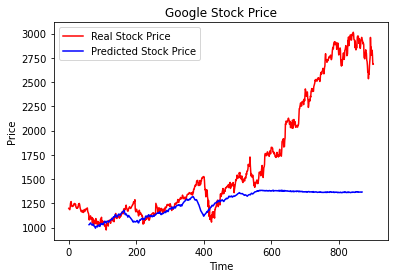

In [312]:
plt.plot(realStockPrice, color = 'red', label = "Real Stock Price")
plt.plot(predictedPrice, color = 'blue', label = "Predicted Stock Price")
plt.title("Google Stock Price")
plt.xlabel('Time')
plt.ylabel("Price")
plt.legend()
plt.show()


In [313]:
stocksOwned = {}
startingValue = 500_000
liquidValue = startingValue

for i in range(len(predictedPrice)):
    if realStockPrice[i] < predictedPrice[i] and 'GOOGL' not in stocksOwned:
        stocksOwned['GOOGL'] = (realStockPrice[i], liquidValue/realStockPrice[i])
        liquidValue -= liquidValue/realStockPrice[i] * realStockPrice[i]
    elif 'GOOGL' in stocksOwned and stocksOwned['GOOGL'][0] < realStockPrice[i]:
        liquidValue += stocksOwned['GOOGL'][1] * realStockPrice[i]
        stocksOwned.pop('GOOGL')

profit = (liquidValue - startingValue)
profitPercentage = (profit/startingValue)*100
print("Profit: ${}".format(round(profit,2)))
print("ROI: {}%".format(round(profitPercentage,2)))
held = (((realStockPrice[-1] - realStockPrice[0]) / realStockPrice[0]) * 100)
print("Held: {}%".format(round(held,2)))


Profit: $536074.98
ROI: 107.21%
Held: 123.96%
